In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/doginsea/WhatsApp Image 2025-02-19 at 22.18.54_37d15852.jpg
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.j

In [2]:
import os
import pandas as pd 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add,BatchNormalization,Embedding,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import glob as glob
import seaborn as sns

In [25]:
img_path='/kaggle/input/flickr8k/Images'
caption_path='/kaggle/input/flickr8k/captions.txt'

In [26]:
img_name='1012212859_01547e3f17.jpg'
img_id=img_name.split('.')[0]
img_id

'1012212859_01547e3f17'

In [27]:
data=pd.read_csv(caption_path)
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [28]:
img_p=os.path.join(img_path,img_name)
img=Image.open(img_p)
plt.imshow(img)

In [29]:
captions=data[data['image']==img_name]['caption']
for c in captions:
    print(c)

A dog shakes its head near the shore , a red ball next to it .
A white dog shakes on the edge of a beach with an orange ball .
Dog with orange ball at feet , stands on shore shaking off water
White dog playing with a red ball on the shore near the water .
White dog with brown ears standing near water with head turned to one side .


In [30]:
data.shape

(40455, 2)

In [31]:
data.isna().sum()

image      0
caption    0
dtype: int64

In [32]:
data[data.duplicated(subset=['caption'])]

image                                       caption
3125   1598085252_f3219b6140.jpg                            A dog in a field .
3432   1731546544_9fbf14617b.jpg          a black dog runs through the water .
5109    210686241_b8e069fff3.jpg                   Children playing in water .
6457   2240539658_dea8db6e55.jpg                Two dogs playing in the snow .
6798   2263655670_517890f5b7.jpg                  Two dogs play in the grass .
...                          ...                                           ...
40040   899810584_61e1578d3f.jpg                   A man climbing a mountain .
40098   925491651_57df3a5b36.jpg  A white dog is splashing through the water .
40200   950411653_20d0335946.jpg                   a boy jumps into the pool .
40322    96973080_783e375945.jpg           A dog is running through the snow .
40323    96973080_783e375945.jpg                 A dog runs through the snow .

[254 rows x 2 columns]

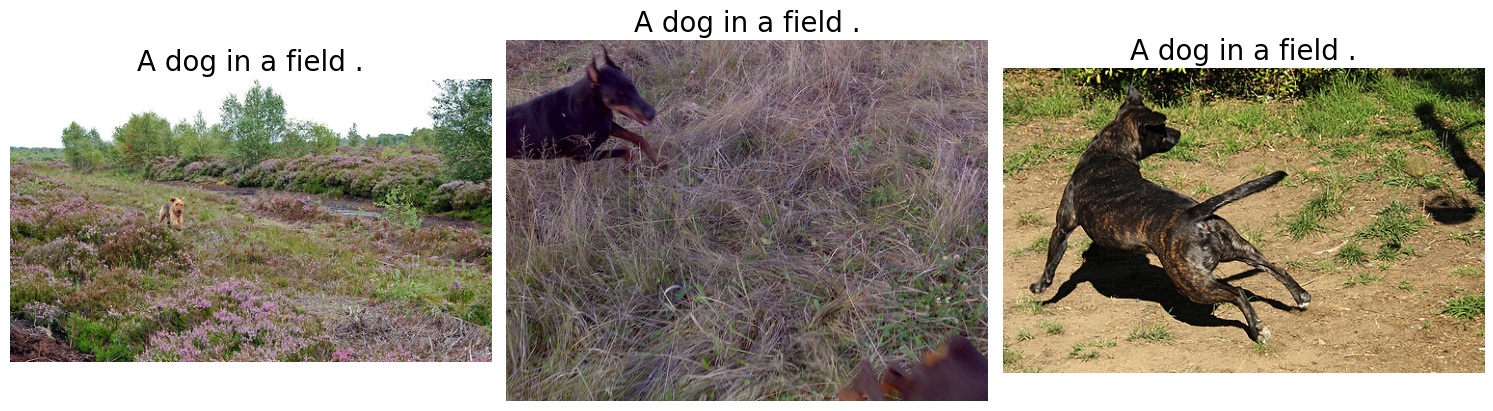

In [33]:
mult_cap = data[data.iloc[3125, 1] == data['caption']]  

num_images = len(mult_cap)
cols = 4  
rows = (num_images // cols) + (1 if num_images % cols != 0 else 0)  

plt.figure(figsize=(20, 5 * rows)) 

for idx, (image_filename, caption) in enumerate(mult_cap[['image', 'caption']].values):
    plt.subplot(rows, cols, idx + 1) 
    img = Image.open(os.path.join(img_path, image_filename)) 
    plt.imshow(img)  
    plt.title(caption, fontsize=20)  
    plt.axis('off') 

plt.tight_layout() 
plt.show() 

# Text Preprocessing

In [34]:
def clean_text (text):
  text= text.lower()
  # Removing punctuation marks
  text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
  text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  text = " ".join([word for word in text.split() if len(word) > 1])
  return text

In [35]:
cleaned_data=data['caption'].apply(clean_text)
for i in cleaned_data.head():
    print(i)

child in pink dress is climbing up set of stairs in an entry way
girl going into wooden building
little girl climbing into wooden playhouse
little girl climbing the stairs to her playhouse
little girl in pink dress going into wooden cabin


In [36]:
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [37]:
caption_IDs=[]
for c in range(len(cleaned_data)):
    item=str(data['image'][c])+'\t'+'start '+cleaned_data[c]+' end\n'
    caption_IDs.append(item)

In [38]:
caption_IDs[:10]

['1000268201_693b08cb0e.jpg\tstart child in pink dress is climbing up set of stairs in an entry way end\n',
 '1000268201_693b08cb0e.jpg\tstart girl going into wooden building end\n',
 '1000268201_693b08cb0e.jpg\tstart little girl climbing into wooden playhouse end\n',
 '1000268201_693b08cb0e.jpg\tstart little girl climbing the stairs to her playhouse end\n',
 '1000268201_693b08cb0e.jpg\tstart little girl in pink dress going into wooden cabin end\n',
 '1001773457_577c3a7d70.jpg\tstart black dog and spotted dog are fighting end\n',
 '1001773457_577c3a7d70.jpg\tstart black dog and tricolored dog playing with each other on the road end\n',
 '1001773457_577c3a7d70.jpg\tstart black dog and white dog with brown spots are staring at each other in the street end\n',
 '1001773457_577c3a7d70.jpg\tstart two dogs of different breeds looking at each other on the road end\n',
 '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n']

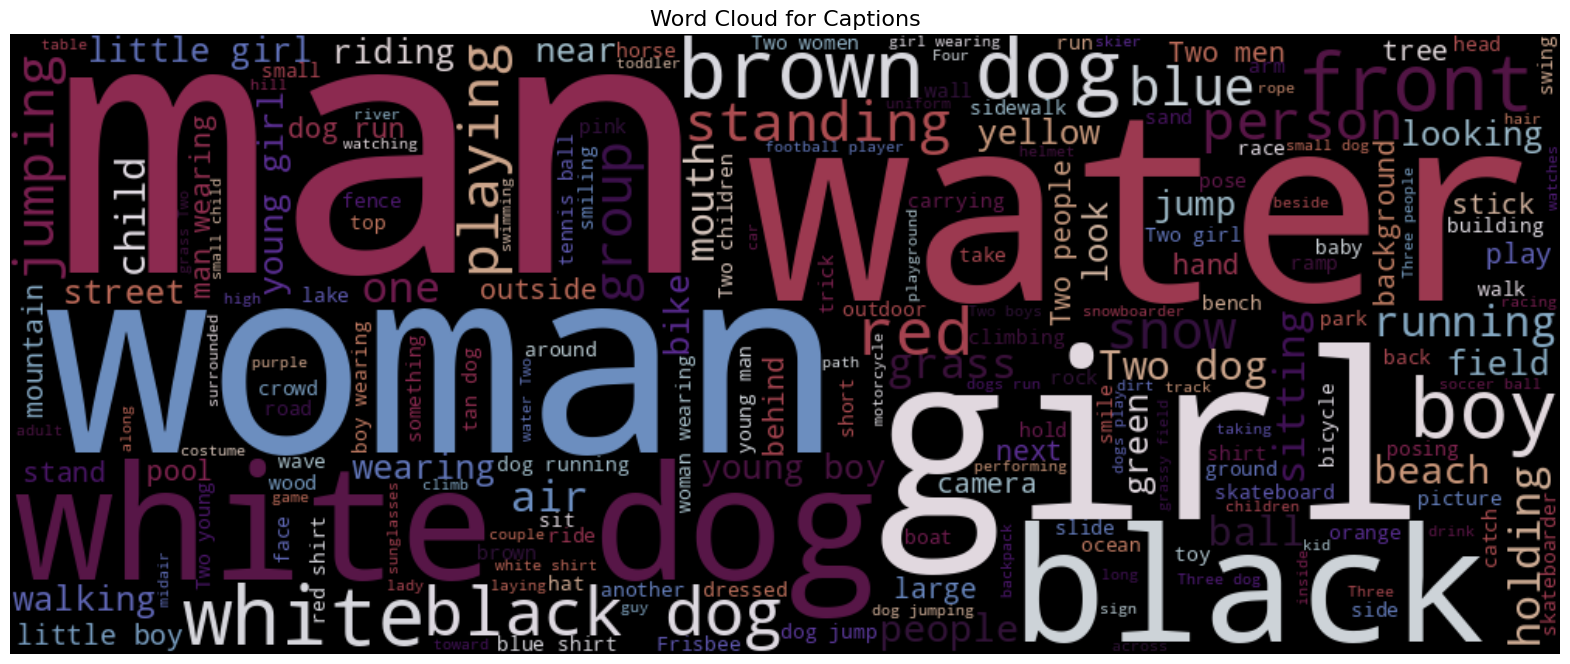

In [39]:
from wordcloud import WordCloud, STOPWORDS
text = " ".join(data['caption'].dropna())  # Drop NaN values if any

# Generate the word cloud
wordcloud = WordCloud(
    width=1000,
    height=400,
    background_color="black",
    stopwords=STOPWORDS,  # Use default stopwords
    colormap="twilight_shifted_r",  # Color scheme
).generate(text)

# Display the WordCloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud for Captions", fontsize=16)
plt.show()

In [17]:
data['caption']=caption_IDs

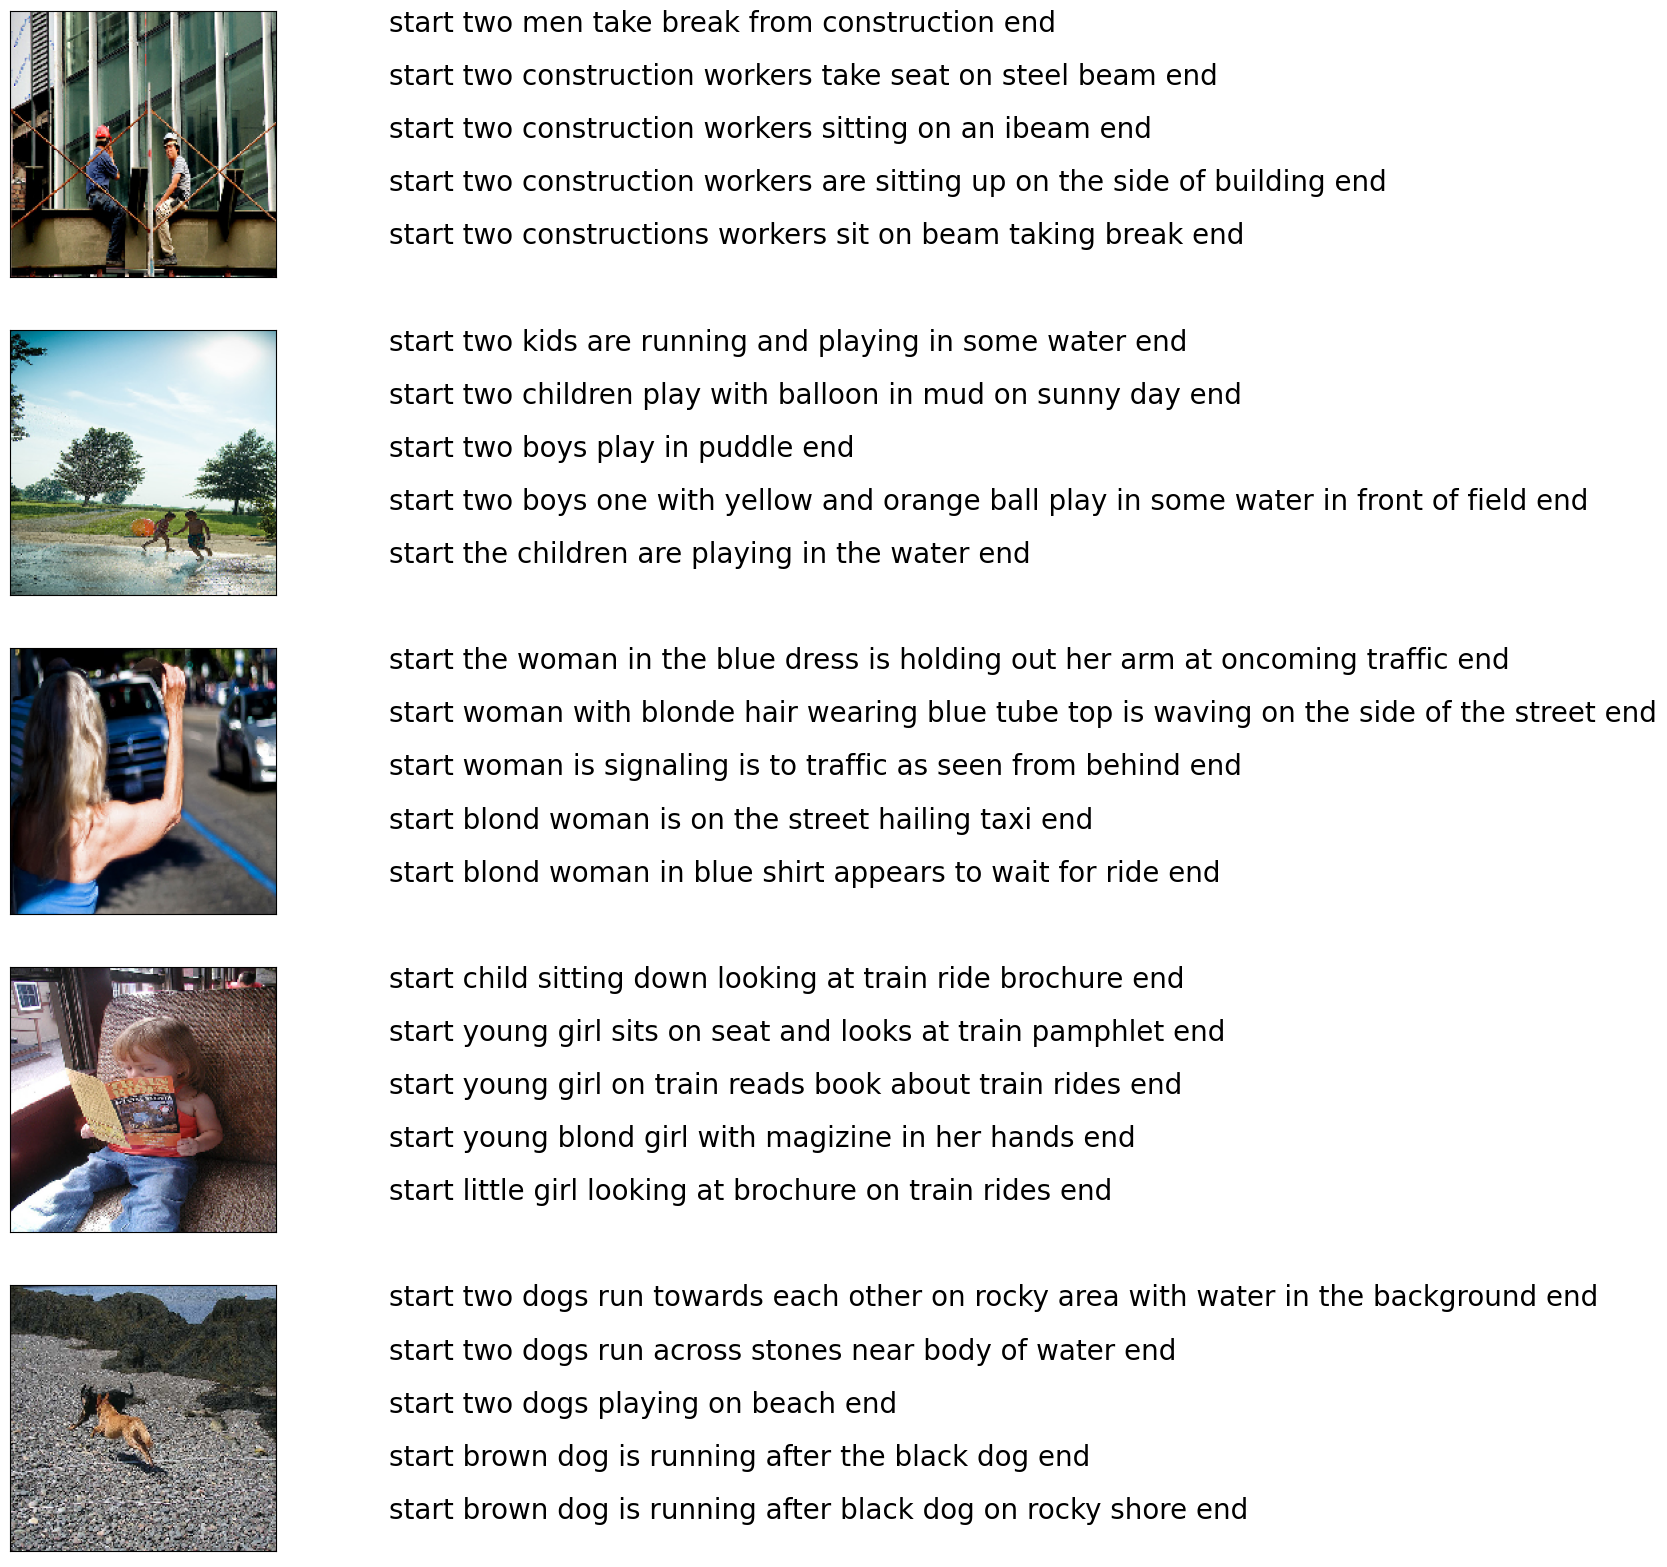

In [18]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[200:200+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(img_path+'/'+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(caption_IDs, 5)

In [24]:
def interactive_caption_histogram(data, title="Interactive Captions Length Histogram", bins=50):
    data = pd.DataFrame({"Caption Length": [len(x.split()) for x in data]})

    fig = px.histogram(
        data, 
        x="Caption Length", 
        nbins=bins, 
        title=title,
        color_discrete_sequence=["#636EFA"],  
        marginal="box"  
    )

    fig.update_layout(
        xaxis_title="Caption Length",
        yaxis_title="Count",
        bargap=0.05  
    )

    fig.show()

interactive_caption_histogram(cleaned_data,bins=30)